Hyperparameter Space:   
1. leanring rates: 1e-2, 1e-3, 1e-4, 1e-5    
3. optimizer: SGD, Adam, RMSDrop   
4. latent dimension: 5%, 10%, 15%, 20%, 50%, 75%   

Main Figures:  
1. 10% top-performed hyperparameter config radar plot, KMUC and UPITT, KUMC and UPITT all model all config f1 score correction.
2. KUMC and UPITT control one hyperparameter and vary on others boxplot, KUMC and UPITT.   
3. t-SNE results of the best config output of each model.
4. Best config, check whether some latent encoding correlates with features.
5. Other distanglement results.

Main Tables:
1. Demographics of 2 centers

# Make Common Dataset

In [1]:
import pandas as pd
import numpy as np
import torch
import pickle
import json
from utils import cross_validation_dataloader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
result_folder = '...'

In [3]:
# Check if MPS (Metal Performance Shaders) is available
if torch.backends.mps.is_available():
    print("MPS (Metal GPU) is available!")
    
    # Get the MPS device
    device = torch.device("mps")
    print(f"Using device: {device}")
else:
    print("MPS is not available. Running on CPU.")

MPS (Metal GPU) is available!
Using device: mps


In [4]:
with open("col_names_ext.json", "r") as file:
    loaded_col_names = json.load(file)

# Extract lists
feature_space_ext = loaded_col_names["feature_space_ext"]
label_col_names = loaded_col_names["label_col_names"]

In [5]:
n_labels = len(label_col_names)

In [6]:
len(feature_space_ext)

654

In [7]:
df = pd.read_csv('./external_dataset.csv')

In [8]:
df[label_col_names[0]].value_counts()

0.0    8678
1.0     890
Name: AKI_LABEL, dtype: int64

In [9]:
df[label_col_names[1]].value_counts()

0.0    8084
1.0    1484
Name: MORT_1_YEAR, dtype: int64

In [ ]:
data_splits = cross_validation_dataloader(df, 5, 256, feature_space_ext, label_col_names)

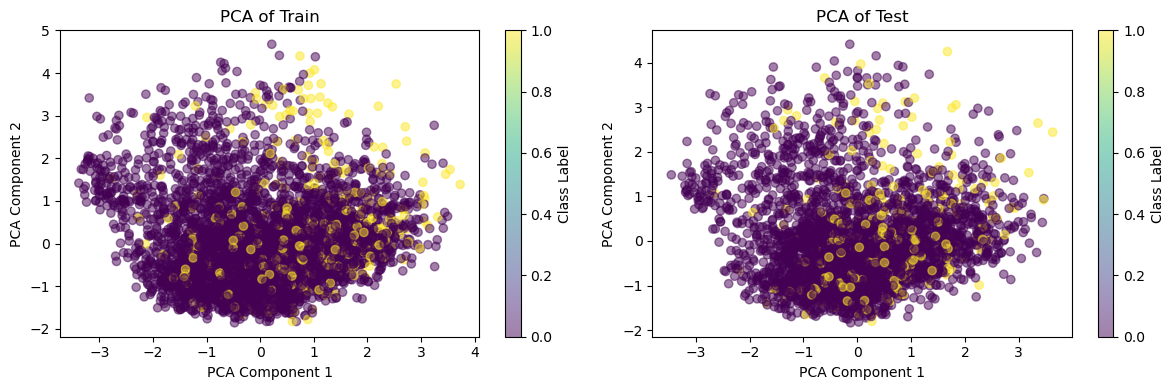

In [11]:
pca = PCA(n_components=2)
# here in data_splits[0][0] represents the first CV setting and we take the train part
# data_splits[0][2] is for the test dataset
X_train_PCA = pca.fit_transform(data_splits[0][0].dataset.features)
X_test_PCA = pca.transform(data_splits[0][2].dataset.features)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
# here we only check the AKI onset label which is 
# data_splits[0][0].dataset.labels[:, 0]
plt.scatter(X_train_PCA[:, 0], X_train_PCA[:, 1], 
            c=data_splits[0][0].dataset.labels[:, 0], 
            cmap='viridis', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Train')
plt.colorbar(label='Class Label')

plt.subplot(1, 2, 2)
plt.scatter(X_test_PCA[:, 0], X_test_PCA[:, 1], c=data_splits[0][2].dataset.labels[:, 0], 
            cmap='viridis', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Test')
plt.colorbar(label='Class Label')
plt.tight_layout()
plt.show()

In [12]:
for train_loader, val_loader, test_loader in data_splits:
    for batch_data, batch_labels in train_loader:
        print("shape of data:", batch_data.shape)
        print("shape of labels:", batch_labels.shape)
        break
    break

shape of data: torch.Size([256, 654])
shape of labels: torch.Size([256, 2])


# Generate Hyperparameter Space

In [13]:
# ranges we want to test for each hyper-parameter
lrs = [1e-2, 1e-3, 1e-4, 1e-5]
optimizers = ['RMSprop', 'Adam', 'Adamax']
latents = [0.02, 0.05, 0.10, 0.15, 0.30, 0.50, 0.75]
activations = ['sigmoid', 'relu']

In [14]:
# generate all configs in form of dict and store in a dict
config_space = dict()
idx = 0
for lr in lrs:
    for opt in optimizers:
        for lat in latents:
            for activation in activations:
                config = {
                    'learning_rate': lr,
                    'optimizer': opt,
                    'latent': lat,
                    'activation': activation,
                }
                config_space[idx] = config
                idx += 1

In [15]:
len(config_space)

168

# Define Train Function

In [16]:
# main function to train a model, each model has its own train_step
def train(model, optimizer, learning_rate, activation, train_step, val_step, 
          train_loader, val_loader, weight_decay, device):
    
    optimizer = define_optimizer(model, optimizer, learning_rate, weight_decay)
    n_epochs = 2000

    #use early stopping
    patience = 5
    best_val_loss = float('inf')
    patience_counter = 0
    min_increment = 5e-5

    with tqdm(range(n_epochs), desc="Training", leave=False) as t:
        for epoch in t:
            train_loss = train_step(model, train_loader, optimizer, device, activation = activation)
            val_loss = val_step(model, val_loader, device)
            
            # tqdm related function
            t.set_postfix(train_loss=train_loss, val_loss=val_loss)

            # if any loss is inf, fail to converge, directly jump out of epoches, 
            # return false
            if val_loss == float('inf'):
                return False, float('inf')

            # Early stopping check: if the increment is still above the
            # the minimum increment threshold, set the counter to zero and
            # continue training
            if val_loss < best_val_loss - min_increment:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
            
            # check whether running out of patience
            if patience_counter >= patience:
                break
            
    # model converged, return True
    return True, float(round(best_val_loss, 3))

In [17]:
# return the optimizer with parameter setted
def define_optimizer(model, optimizer, learning_rate, weight_decay):
    
    optimizer_dict = {
        'Adamax': torch.optim.Adamax,
        'Adam': torch.optim.Adam,
        'RMSprop': torch.optim.RMSprop,
    }
    
    return optimizer_dict[optimizer](model.parameters(), 
                                     lr = learning_rate, 
                                     weight_decay = weight_decay)

# Evaluation Functions

In [18]:
from tqdm import tqdm
import gc
# AE net architecture remains consistent across all models
from AE_nn import AE
from AE_utils import train_step_AE, val_step_AE
from DAE_utils import train_step_DAE, val_step_DAE
from CAE_utils import train_step_CAE, val_step_CAE
from SAE_utils import train_step_SAE, val_step_SAE
from RAE_utils import train_step_RAE, val_step_RAE

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, log_loss, roc_auc_score, average_precision_score

In [20]:
model_names = ['AE', 'DAE', 'CAE', 'SAE', 'RAE']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
# different neighborhood sizes, we only use Euc here
knn_model_dict = {
    'Euc_5': KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean'),
    'Euc_10': KNeighborsClassifier(n_neighbors = 10, metric = 'euclidean'),
    'Euc_15': KNeighborsClassifier(n_neighbors = 15, metric = 'euclidean'),
    'Euc_20': KNeighborsClassifier(n_neighbors = 20, metric = 'euclidean'),
}

In [22]:
def evaluate_KNN_and_cluster(train_loader, test_loader, model):
    # transform data by models
    # note that we have 3 labels here
    X_train_AE, y_train_AE = get_transformed_data(train_loader, model)
    X_test_AE, y_test_AE = get_transformed_data(test_loader, model)
    
    results = dict()
    results['F1'] = []
    results['AUROC'] = []
    results['AUPRC'] = []

    # use different KNN model with different neighborhood sizes to evaluate the quality of the similar patients 
    with tqdm(knn_model_dict.items(), desc="Evaluating KNN models", leave=False) as t:
        for name, knn_model in t:
            f1s, aurocs, auprcs = knn_evaluation(knn_model, X_train_AE, y_train_AE, X_test_AE, y_test_AE)
            results['F1'].append(f1s)
            results['AUROC'].append(aurocs)
            results['AUPRC'].append(auprcs)
    
    return results

In [23]:
def get_transformed_data(dataloader, model):

    if model is not None:
        model.eval()
        
    features = dataloader.dataset.features.to(device)
    labels = dataloader.dataset.labels.to(device)
    
    outputs = model(features)
    embedding = outputs[0]
    embedding = embedding.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    return embedding, labels

In [24]:
def knn_evaluation(knn_model, X_train, y_train, X_test, y_test):
    
    if len(y_train.shape) < 2:
        # if we have single label
        n_labels = 1
        y_train, y_test = y_train.view(-1, 1), y_test.view(-1, 1)
    else:
        # we have multiple labels here
        n_labels = y_train.shape[1]
        
    f1_l = []
    auroc_l = []
    auprc_l = []
    
    for l in range(n_labels):
    # fit model on training set
        y_train_single = y_train[:, l]
        y_test_single = y_test[:, l]
        
        knn_model.fit(X_train, y_train_single)
        # make prediction on test set
        yhat = knn_model.predict(X_test)
        yprob = knn_model.predict_proba(X_test)[:, 1]

        # calculate accuracy
        f1 = f1_score(y_test_single, yhat, zero_division = 0)
        f1_l.append(f1)
        auroc = roc_auc_score(y_test_single, yprob)
        auroc_l.append(auroc)
        auprc = average_precision_score(y_test_single, yprob)
        auprc_l.append(auprc)

    return f1_l, auroc_l, auprc_l

In [25]:
def compute_BCE_loss_on_positive_labels(y_test, y_test_pred_probs):
    assert len(y_test) == len(y_test_pred_probs)
    y_test, y_test_pred_probs = np.array(y_test), np.array(y_test_pred_probs)
    
    y_test_positive = y_test[y_test == 1]
    y_pred_probs_positive = y_test_pred_probs[y_test == 1]

    
    positive_log_loss = log_loss(y_test_positive, y_pred_probs_positive, labels=[0, 1])
    return positive_log_loss

In [26]:
def empty_space(AE_model):
    del AE_model
    gc.collect()
    torch.cuda.empty_cache()

# Get Performance from Raw Data

In [27]:
# label_idx is the i-th label we want to evalute on
def evaluate_raw_data_performance(data_splits, label_idx):
    # collect results from CV
    raw_performance_dfs = []
    
    for train_loader, _, test_loader in (data_splits):
        # reconstruct train and test, we only use the AKI onset as the target
        X_train_raw = train_loader.dataset.features
        y_train_raw = train_loader.dataset.labels[:, label_idx]
        X_test_raw = test_loader.dataset.features
        y_test_raw = test_loader.dataset.labels[:, label_idx]
    
        raw_performance = pd.DataFrame(0.0, index = list(knn_model_dict.keys()),
                                columns = ['F1', 'AUROC', 'AUPRC'])

        for name, knn_model in tqdm(knn_model_dict.items()):
            f1s, aurocs, auprcs = knn_evaluation(knn_model, X_train_raw, y_train_raw, X_test_raw, y_test_raw)
            raw_performance.loc[name, 'F1'] = f1s[0]
            raw_performance.loc[name, 'AUROC'] = aurocs[0]
            raw_performance.loc[name, 'AUPRC'] = auprcs[0]

        
        raw_performance_dfs.append(raw_performance)
    
    performance_arrs = [df.to_numpy() for df in raw_performance_dfs]

    # Compute the mean across the stacked arrays
    raw_performance_mean = np.mean(performance_arrs, axis=0)
    raw_performance_std = np.std(performance_arrs, axis=0)

    # Convert back to a DataFrame
    performance_mean = pd.DataFrame(raw_performance_mean, columns=[col+'_mean_%s'%(label_idx) for col in raw_performance_dfs[0].columns])
    performance_std = pd.DataFrame(raw_performance_std, columns=[col+'_std_%s'%(label_idx) for col in raw_performance_dfs[0].columns])

    return performance_mean, performance_std


In [28]:
performance_mean_label_1, performance_std_label_1 = evaluate_raw_data_performance(data_splits, 0)

100%|██████████| 4/4 [00:00<00:00,  6.08it/s]


In [29]:
performance_mean_label_2, performance_std_label_2 = evaluate_raw_data_performance(data_splits, 1)

100%|██████████| 4/4 [00:00<00:00,  5.84it/s]


In [30]:
raw_data_performance = pd.concat([performance_mean_label_1, performance_std_label_1, performance_mean_label_2, performance_std_label_2],axis = 1)

In [31]:
raw_data_performance

,F1_mean_0,AUROC_mean_0,AUPRC_mean_0,F1_std_0,AUROC_std_0,AUPRC_std_0,F1_mean_1,AUROC_mean_1,AUPRC_mean_1,F1_std_1,AUROC_std_1,AUPRC_std_1
0,0.092970,0.618140,0.176206,0.014901,0.009983,0.023964,0.139892,0.644462,0.254860,0.033989,0.014425,0.011151
1,0.055417,0.639192,0.210493,0.011471,0.009862,0.021615,0.038362,0.680090,0.285726,0.018499,0.013029,0.018205
2,0.048654,0.656630,0.221258,0.015457,0.010773,0.017913,0.025360,0.698416,0.300364,0.011969,0.015311,0.025819
3,0.029897,0.661304,0.229383,0.012644,0.017710,0.018030,0.006897,0.711503,0.309615,0.007101,0.015586,0.026760


In [ ]:
raw_data_performance.to_csv(result_folder + 'raw_data_performance_ext.csv', index = True)

# Evaluation

In [32]:
torch.cuda.manual_seed_all(42)

In [33]:
def evaluate_models_main(model_name, activation, weight_decay, train_step_AE, val_step_AE):
    final_results_dict = dict()
    AE_results_cv = []
    
    # loop through hyperparameters
    for i, config in config_space.items():
        
        # get hyperparameters
        input_dim = len(feature_space_ext)
        latent_dim = int(config['latent'] * input_dim)
        learning_rate = config['learning_rate']
        optimizer_name = config['optimizer']
        activation = config['activation']
        print('i = %s, lr = %s, opt = %s, latent_pct = %s, activation = %s, '%(i, learning_rate, optimizer_name, 
                                                                               config['latent'], activation))
        
        for train_loader, val_loader, test_loader in (data_splits):
            AE_model = AE(input_dim, latent_dim, activation).to(device)
            AE_converged, AE_val_loss = train(AE_model, optimizer_name, learning_rate, activation,
                                              train_step_AE, val_step_AE,
                                              train_loader, val_loader, weight_decay, device)
            
            # evaluate model by patient similarity KNN
            if AE_converged:
                AE_results = evaluate_KNN_and_cluster(train_loader, test_loader, AE_model)
                AE_results['val_loss'] = AE_val_loss
                AE_results_cv.append(AE_results)
            else:
                AE_results = None
            
            empty_space(AE_model)
            
        AE_perf_mean, AE_perf_std = avg_performance_dict(AE_results_cv)
        final_results_dict[i] = {'performance mean': AE_perf_mean, 'performance std': AE_perf_std}
        print('%s mean='%(model_name), AE_perf_mean)
        
    return final_results_dict

In [34]:
from collections import defaultdict

def avg_performance_dict(dicts):
    # Initialize a defaultdict for accumulating sums and counts
    accumulated = defaultdict(list)

    # Accumulate values from all dictionaries
    for d in dicts:
        for key, value in d.items():
            accumulated[key].append(value)

    # Calculate the mean for each key
    mean_dict = {}
    std_dict = {}
    for key, values in accumulated.items():
        if isinstance(values[0], list):
            # Compute the element-wise mean for lists
            mean_dict[key] = np.round(np.mean(values, axis=0), 3).tolist()
            std_dict[key] = np.round(np.std(values, axis=0), 3).tolist()
        else:
            # Compute the mean for single values
            mean_dict[key] = np.round(np.mean(values), 3)
            std_dict[key] = np.round(np.std(values), 3)
    return mean_dict, std_dict

In [35]:
model_funcs = {
    'AE': {'train': train_step_AE, 'val': val_step_AE},
    'DAE': {'train': train_step_DAE, 'val': val_step_DAE},
    'CAE': {'train': train_step_CAE, 'val': val_step_CAE},
    'SAE': {'train': train_step_SAE, 'val': val_step_SAE},
    'RAE': {'train': train_step_RAE, 'val': val_step_RAE},
}

# Main Run

In [ ]:
final_results_dict_collection = []
for model_name in model_names:
    # define train and val funcs
    model_train_step = model_funcs[model_name]['train']
    model_val_step = model_funcs[model_name]['val']
        
    #define weight decay 
    if model_name == 'RAE':
        weight_decay = 0.03
    else:
        weight_decay = 0
    
    final_results_dict = evaluate_models_main(model_name, activation, weight_decay, 
                                              model_train_step, model_val_step)
    
    # save results
    final_results_dict_collection.append(final_results_dict)
    with open(result_folder + '%s_results.pkl'%(model_name), 'wb') as file:
        pickle.dump(final_results_dict, file)

i = 0, lr = 0.01, opt = RMSprop, latent_pct = 0.02, activation = sigmoid, 


AE mean= {'AUROC': [[0.617, 0.654], [0.648, 0.69], [0.659, 0.699], [0.672, 0.712]], 'AUPRC': [[0.15, 0.244], [0.173, 0.271], [0.18, 0.286], [0.186, 0.305]], 'val_loss': 0.034}
i = 1, lr = 0.01, opt = RMSprop, latent_pct = 0.02, activation = relu, 


AE mean= {'AUROC': [[0.597, 0.625], [0.631, 0.654], [0.646, 0.663], [0.654, 0.674]], 'AUPRC': [[0.144, 0.225], [0.167, 0.249], [0.179, 0.259], [0.183, 0.274]], 'val_loss': 0.038}
i = 2, lr = 0.01, opt = RMSprop, latent_pct = 0.05, activation = sigmoid, 


AE mean= {'AUROC': [[0.609, 0.638], [0.645, 0.67], [0.662, 0.683], [0.671, 0.693]], 'AUPRC': [[0.158, 0.238], [0.186, 0.264], [0.201, 0.279], [0.209, 0.293]], 'val_loss': 0.035}
i = 3, lr = 0.01, opt = RMSprop, latent_pct = 0.05, activation = relu, 


AE mean= {'AUROC': [[0.612, 0.646], [0.647, 0.677], [0.664, 0.691], [0.673, 0.7]], 'AUPRC': [[0.161, 0.246], [0.188, 0.271], [0.204, 0.288], [0.211, 0.301]], 'val_loss': 0.034}
i = 4, lr = 0.01, opt = RMSprop, latent_pct = 0.1, activation = sigmoid, 


AE mean= {'AUROC': [[0.622, 0.653], [0.655, 0.683], [0.67, 0.699], [0.68, 0.709]], 'AUPRC': [[0.169, 0.253], [0.198, 0.279], [0.213, 0.298], [0.222, 0.312]], 'val_loss': 0.031}
i = 5, lr = 0.01, opt = RMSprop, latent_pct = 0.1, activation = relu, 


AE mean= {'AUROC': [[0.625, 0.655], [0.658, 0.688], [0.674, 0.704], [0.683, 0.713]], 'AUPRC': [[0.172, 0.256], [0.202, 0.285], [0.217, 0.304], [0.226, 0.317]], 'val_loss': 0.031}
i = 6, lr = 0.01, opt = RMSprop, latent_pct = 0.15, activation = sigmoid, 


AE mean= {'AUROC': [[0.626, 0.656], [0.66, 0.691], [0.678, 0.707], [0.686, 0.716]], 'AUPRC': [[0.174, 0.257], [0.207, 0.289], [0.223, 0.308], [0.233, 0.321]], 'val_loss': 0.029}
i = 7, lr = 0.01, opt = RMSprop, latent_pct = 0.15, activation = relu, 


AE mean= {'AUROC': [[0.629, 0.658], [0.664, 0.694], [0.681, 0.71], [0.689, 0.719]], 'AUPRC': [[0.178, 0.258], [0.211, 0.292], [0.227, 0.312], [0.236, 0.325]], 'val_loss': 0.028}
i = 8, lr = 0.01, opt = RMSprop, latent_pct = 0.3, activation = sigmoid, 


AE mean= {'AUROC': [[0.629, 0.658], [0.664, 0.694], [0.681, 0.711], [0.689, 0.72]], 'AUPRC': [[0.178, 0.26], [0.213, 0.295], [0.23, 0.314], [0.238, 0.327]], 'val_loss': 0.026}
i = 9, lr = 0.01, opt = RMSprop, latent_pct = 0.3, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.654], [0.662, 0.689], [0.679, 0.706], [0.687, 0.714]], 'AUPRC': [[0.176, 0.255], [0.21, 0.289], [0.227, 0.307], [0.235, 0.32]], 'val_loss': 0.03}
i = 10, lr = 0.01, opt = RMSprop, latent_pct = 0.5, activation = sigmoid, 


AE mean= {'AUROC': [[0.628, 0.654], [0.661, 0.689], [0.678, 0.705], [0.687, 0.713]], 'AUPRC': [[0.177, 0.255], [0.21, 0.289], [0.227, 0.306], [0.236, 0.318]], 'val_loss': 0.031}
i = 11, lr = 0.01, opt = RMSprop, latent_pct = 0.5, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.651], [0.661, 0.686], [0.677, 0.701], [0.686, 0.71]], 'AUPRC': [[0.175, 0.253], [0.208, 0.286], [0.225, 0.302], [0.233, 0.314]], 'val_loss': 0.034}
i = 12, lr = 0.01, opt = RMSprop, latent_pct = 0.75, activation = sigmoid, 


AE mean= {'AUROC': [[0.629, 0.65], [0.661, 0.685], [0.677, 0.7], [0.686, 0.708]], 'AUPRC': [[0.175, 0.251], [0.207, 0.283], [0.224, 0.3], [0.232, 0.311]], 'val_loss': 0.036}
i = 13, lr = 0.01, opt = RMSprop, latent_pct = 0.75, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.648], [0.661, 0.682], [0.676, 0.697], [0.686, 0.705]], 'AUPRC': [[0.174, 0.249], [0.206, 0.281], [0.222, 0.296], [0.23, 0.308]], 'val_loss': 0.038}
i = 14, lr = 0.01, opt = Adam, latent_pct = 0.02, activation = sigmoid, 


AE mean= {'AUROC': [[0.626, 0.641], [0.658, 0.673], [0.674, 0.688], [0.683, 0.696]], 'AUPRC': [[0.171, 0.244], [0.203, 0.274], [0.218, 0.289], [0.227, 0.299]], 'val_loss': 0.038}
i = 15, lr = 0.01, opt = Adam, latent_pct = 0.02, activation = relu, 


AE mean= {'AUROC': [[0.623, 0.637], [0.654, 0.669], [0.67, 0.684], [0.679, 0.692]], 'AUPRC': [[0.169, 0.241], [0.2, 0.271], [0.215, 0.285], [0.224, 0.296]], 'val_loss': 0.039}
i = 16, lr = 0.01, opt = Adam, latent_pct = 0.05, activation = sigmoid, 


AE mean= {'AUROC': [[0.624, 0.637], [0.654, 0.67], [0.67, 0.684], [0.679, 0.693]], 'AUPRC': [[0.169, 0.241], [0.2, 0.271], [0.215, 0.285], [0.223, 0.296]], 'val_loss': 0.038}
i = 17, lr = 0.01, opt = Adam, latent_pct = 0.05, activation = relu, 


AE mean= {'AUROC': [[0.624, 0.638], [0.655, 0.671], [0.67, 0.686], [0.679, 0.694]], 'AUPRC': [[0.169, 0.241], [0.199, 0.272], [0.215, 0.287], [0.223, 0.297]], 'val_loss': 0.038}
i = 18, lr = 0.01, opt = Adam, latent_pct = 0.1, activation = sigmoid, 


AE mean= {'AUROC': [[0.625, 0.64], [0.656, 0.673], [0.672, 0.687], [0.681, 0.696]], 'AUPRC': [[0.17, 0.242], [0.2, 0.274], [0.216, 0.289], [0.225, 0.299]], 'val_loss': 0.037}
i = 19, lr = 0.01, opt = Adam, latent_pct = 0.1, activation = relu, 


AE mean= {'AUROC': [[0.626, 0.64], [0.657, 0.673], [0.673, 0.688], [0.682, 0.696]], 'AUPRC': [[0.171, 0.242], [0.202, 0.274], [0.217, 0.289], [0.226, 0.3]], 'val_loss': 0.037}
i = 20, lr = 0.01, opt = Adam, latent_pct = 0.15, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.642], [0.658, 0.675], [0.673, 0.69], [0.682, 0.698]], 'AUPRC': [[0.171, 0.244], [0.202, 0.275], [0.218, 0.29], [0.226, 0.301]], 'val_loss': 0.036}
i = 21, lr = 0.01, opt = Adam, latent_pct = 0.15, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.642], [0.658, 0.675], [0.674, 0.69], [0.682, 0.698]], 'AUPRC': [[0.171, 0.243], [0.202, 0.275], [0.218, 0.29], [0.227, 0.301]], 'val_loss': 0.036}
i = 22, lr = 0.01, opt = Adam, latent_pct = 0.3, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.643], [0.658, 0.676], [0.673, 0.691], [0.682, 0.699]], 'AUPRC': [[0.172, 0.244], [0.203, 0.276], [0.218, 0.291], [0.227, 0.302]], 'val_loss': 0.035}
i = 23, lr = 0.01, opt = Adam, latent_pct = 0.3, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.643], [0.658, 0.676], [0.674, 0.691], [0.682, 0.7]], 'AUPRC': [[0.172, 0.244], [0.203, 0.276], [0.219, 0.291], [0.228, 0.302]], 'val_loss': 0.035}
i = 24, lr = 0.01, opt = Adam, latent_pct = 0.5, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.644], [0.658, 0.677], [0.674, 0.692], [0.682, 0.7]], 'AUPRC': [[0.172, 0.245], [0.203, 0.277], [0.219, 0.292], [0.228, 0.303]], 'val_loss': 0.033}
i = 25, lr = 0.01, opt = Adam, latent_pct = 0.5, activation = relu, 


AE mean= {'AUROC': [[0.627, 0.644], [0.658, 0.677], [0.674, 0.693], [0.682, 0.701]], 'AUPRC': [[0.173, 0.245], [0.204, 0.277], [0.219, 0.293], [0.228, 0.303]], 'val_loss': 0.034}
i = 26, lr = 0.01, opt = Adam, latent_pct = 0.75, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.645], [0.658, 0.678], [0.674, 0.693], [0.682, 0.702]], 'AUPRC': [[0.173, 0.246], [0.204, 0.278], [0.219, 0.294], [0.228, 0.304]], 'val_loss': 0.033}
i = 27, lr = 0.01, opt = Adam, latent_pct = 0.75, activation = relu, 


AE mean= {'AUROC': [[0.627, 0.645], [0.658, 0.679], [0.674, 0.694], [0.682, 0.702]], 'AUPRC': [[0.173, 0.246], [0.204, 0.278], [0.219, 0.294], [0.228, 0.305]], 'val_loss': 0.033}
i = 28, lr = 0.01, opt = Adamax, latent_pct = 0.02, activation = sigmoid, 


AE mean= {'AUROC': [[0.625, 0.642], [0.657, 0.674], [0.672, 0.689], [0.68, 0.698]], 'AUPRC': [[0.171, 0.243], [0.203, 0.274], [0.217, 0.29], [0.226, 0.3]], 'val_loss': 0.033}
i = 29, lr = 0.01, opt = Adamax, latent_pct = 0.02, activation = relu, 


AE mean= {'AUROC': [[0.625, 0.641], [0.656, 0.674], [0.672, 0.689], [0.68, 0.697]], 'AUPRC': [[0.171, 0.243], [0.202, 0.274], [0.217, 0.289], [0.226, 0.3]], 'val_loss': 0.034}
i = 30, lr = 0.01, opt = Adamax, latent_pct = 0.05, activation = sigmoid, 


AE mean= {'AUROC': [[0.625, 0.641], [0.656, 0.673], [0.671, 0.688], [0.68, 0.697]], 'AUPRC': [[0.171, 0.242], [0.201, 0.272], [0.216, 0.288], [0.225, 0.298]], 'val_loss': 0.034}
i = 31, lr = 0.01, opt = Adamax, latent_pct = 0.05, activation = relu, 


AE mean= {'AUROC': [[0.625, 0.641], [0.656, 0.674], [0.671, 0.689], [0.68, 0.698]], 'AUPRC': [[0.171, 0.243], [0.202, 0.273], [0.217, 0.289], [0.226, 0.299]], 'val_loss': 0.034}
i = 32, lr = 0.01, opt = Adamax, latent_pct = 0.1, activation = sigmoid, 


AE mean= {'AUROC': [[0.625, 0.642], [0.656, 0.674], [0.672, 0.69], [0.68, 0.699]], 'AUPRC': [[0.172, 0.243], [0.202, 0.274], [0.217, 0.289], [0.226, 0.3]], 'val_loss': 0.033}
i = 33, lr = 0.01, opt = Adamax, latent_pct = 0.1, activation = relu, 


AE mean= {'AUROC': [[0.626, 0.643], [0.658, 0.675], [0.673, 0.69], [0.682, 0.7]], 'AUPRC': [[0.172, 0.244], [0.203, 0.275], [0.219, 0.291], [0.227, 0.301]], 'val_loss': 0.033}
i = 34, lr = 0.01, opt = Adamax, latent_pct = 0.15, activation = sigmoid, 


AE mean= {'AUROC': [[0.626, 0.643], [0.658, 0.676], [0.673, 0.691], [0.682, 0.7]], 'AUPRC': [[0.173, 0.245], [0.204, 0.276], [0.219, 0.292], [0.228, 0.302]], 'val_loss': 0.033}
i = 35, lr = 0.01, opt = Adamax, latent_pct = 0.15, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.644], [0.659, 0.677], [0.674, 0.692], [0.683, 0.701]], 'AUPRC': [[0.174, 0.246], [0.205, 0.277], [0.22, 0.293], [0.229, 0.304]], 'val_loss': 0.032}
i = 36, lr = 0.01, opt = Adamax, latent_pct = 0.3, activation = sigmoid, 


AE mean= {'AUROC': [[0.628, 0.645], [0.659, 0.677], [0.674, 0.693], [0.683, 0.702]], 'AUPRC': [[0.174, 0.246], [0.206, 0.277], [0.221, 0.293], [0.23, 0.304]], 'val_loss': 0.032}
i = 37, lr = 0.01, opt = Adamax, latent_pct = 0.3, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.645], [0.66, 0.678], [0.675, 0.694], [0.684, 0.702]], 'AUPRC': [[0.174, 0.247], [0.206, 0.278], [0.221, 0.294], [0.23, 0.305]], 'val_loss': 0.031}
i = 38, lr = 0.01, opt = Adamax, latent_pct = 0.5, activation = sigmoid, 


AE mean= {'AUROC': [[0.628, 0.645], [0.659, 0.678], [0.674, 0.694], [0.683, 0.703]], 'AUPRC': [[0.174, 0.247], [0.206, 0.278], [0.221, 0.295], [0.23, 0.305]], 'val_loss': 0.031}
i = 39, lr = 0.01, opt = Adamax, latent_pct = 0.5, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.646], [0.66, 0.679], [0.675, 0.694], [0.683, 0.703]], 'AUPRC': [[0.175, 0.248], [0.207, 0.28], [0.221, 0.296], [0.231, 0.306]], 'val_loss': 0.03}
i = 40, lr = 0.01, opt = Adamax, latent_pct = 0.75, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.646], [0.659, 0.679], [0.674, 0.694], [0.683, 0.703]], 'AUPRC': [[0.175, 0.248], [0.206, 0.28], [0.221, 0.296], [0.23, 0.306]], 'val_loss': 0.029}
i = 41, lr = 0.01, opt = Adamax, latent_pct = 0.75, activation = relu, 


AE mean= {'AUROC': [[0.627, 0.646], [0.659, 0.679], [0.674, 0.694], [0.682, 0.703]], 'AUPRC': [[0.175, 0.248], [0.207, 0.28], [0.221, 0.296], [0.23, 0.306]], 'val_loss': 0.029}
i = 42, lr = 0.001, opt = RMSprop, latent_pct = 0.02, activation = sigmoid, 


AE mean= {'AUROC': [[0.626, 0.644], [0.658, 0.677], [0.673, 0.692], [0.681, 0.701]], 'AUPRC': [[0.174, 0.246], [0.206, 0.278], [0.22, 0.294], [0.229, 0.304]], 'val_loss': 0.03}
i = 43, lr = 0.001, opt = RMSprop, latent_pct = 0.02, activation = relu, 


AE mean= {'AUROC': [[0.626, 0.644], [0.658, 0.677], [0.673, 0.692], [0.681, 0.701]], 'AUPRC': [[0.174, 0.246], [0.205, 0.278], [0.22, 0.294], [0.229, 0.304]], 'val_loss': 0.03}
i = 44, lr = 0.001, opt = RMSprop, latent_pct = 0.05, activation = sigmoid, 


AE mean= {'AUROC': [[0.626, 0.643], [0.657, 0.676], [0.672, 0.69], [0.681, 0.699]], 'AUPRC': [[0.173, 0.245], [0.205, 0.277], [0.219, 0.292], [0.228, 0.302]], 'val_loss': 0.03}
i = 45, lr = 0.001, opt = RMSprop, latent_pct = 0.05, activation = relu, 


AE mean= {'AUROC': [[0.626, 0.643], [0.658, 0.677], [0.673, 0.691], [0.681, 0.7]], 'AUPRC': [[0.173, 0.246], [0.205, 0.277], [0.22, 0.293], [0.228, 0.303]], 'val_loss': 0.03}
i = 46, lr = 0.001, opt = RMSprop, latent_pct = 0.1, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.644], [0.658, 0.677], [0.673, 0.692], [0.682, 0.701]], 'AUPRC': [[0.174, 0.246], [0.206, 0.278], [0.22, 0.294], [0.229, 0.304]], 'val_loss': 0.03}
i = 47, lr = 0.001, opt = RMSprop, latent_pct = 0.1, activation = relu, 


AE mean= {'AUROC': [[0.627, 0.645], [0.659, 0.678], [0.674, 0.693], [0.682, 0.702]], 'AUPRC': [[0.174, 0.247], [0.206, 0.279], [0.221, 0.295], [0.23, 0.305]], 'val_loss': 0.03}
i = 48, lr = 0.001, opt = RMSprop, latent_pct = 0.15, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.645], [0.659, 0.679], [0.674, 0.694], [0.682, 0.702]], 'AUPRC': [[0.175, 0.247], [0.206, 0.28], [0.221, 0.296], [0.23, 0.306]], 'val_loss': 0.029}
i = 49, lr = 0.001, opt = RMSprop, latent_pct = 0.15, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.646], [0.66, 0.679], [0.674, 0.694], [0.683, 0.703]], 'AUPRC': [[0.175, 0.248], [0.207, 0.28], [0.222, 0.297], [0.231, 0.307]], 'val_loss': 0.029}
i = 50, lr = 0.001, opt = RMSprop, latent_pct = 0.3, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.646], [0.659, 0.679], [0.674, 0.695], [0.683, 0.703]], 'AUPRC': [[0.175, 0.248], [0.207, 0.281], [0.222, 0.297], [0.231, 0.307]], 'val_loss': 0.029}
i = 51, lr = 0.001, opt = RMSprop, latent_pct = 0.3, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.646], [0.66, 0.68], [0.675, 0.695], [0.683, 0.704]], 'AUPRC': [[0.175, 0.249], [0.208, 0.281], [0.223, 0.297], [0.231, 0.308]], 'val_loss': 0.028}
i = 52, lr = 0.001, opt = RMSprop, latent_pct = 0.5, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.646], [0.659, 0.68], [0.674, 0.695], [0.683, 0.704]], 'AUPRC': [[0.175, 0.249], [0.207, 0.281], [0.222, 0.297], [0.231, 0.308]], 'val_loss': 0.028}
i = 53, lr = 0.001, opt = RMSprop, latent_pct = 0.5, activation = relu, 


AE mean= {'AUROC': [[0.627, 0.646], [0.659, 0.68], [0.674, 0.695], [0.683, 0.704]], 'AUPRC': [[0.176, 0.249], [0.208, 0.281], [0.223, 0.298], [0.231, 0.308]], 'val_loss': 0.027}
i = 54, lr = 0.001, opt = RMSprop, latent_pct = 0.75, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.646], [0.659, 0.68], [0.674, 0.695], [0.682, 0.704]], 'AUPRC': [[0.176, 0.249], [0.208, 0.281], [0.223, 0.298], [0.231, 0.308]], 'val_loss': 0.027}
i = 55, lr = 0.001, opt = RMSprop, latent_pct = 0.75, activation = relu, 


AE mean= {'AUROC': [[0.627, 0.646], [0.659, 0.68], [0.674, 0.696], [0.682, 0.704]], 'AUPRC': [[0.176, 0.249], [0.208, 0.282], [0.223, 0.298], [0.232, 0.309]], 'val_loss': 0.027}
i = 56, lr = 0.001, opt = Adam, latent_pct = 0.02, activation = sigmoid, 


AE mean= {'AUROC': [[0.626, 0.645], [0.658, 0.678], [0.673, 0.693], [0.681, 0.702]], 'AUPRC': [[0.175, 0.248], [0.207, 0.28], [0.222, 0.296], [0.231, 0.307]], 'val_loss': 0.027}
i = 57, lr = 0.001, opt = Adam, latent_pct = 0.02, activation = relu, 


AE mean= {'AUROC': [[0.626, 0.645], [0.658, 0.678], [0.673, 0.693], [0.681, 0.702]], 'AUPRC': [[0.175, 0.248], [0.207, 0.28], [0.222, 0.296], [0.23, 0.307]], 'val_loss': 0.027}
i = 58, lr = 0.001, opt = Adam, latent_pct = 0.05, activation = sigmoid, 


AE mean= {'AUROC': [[0.626, 0.644], [0.657, 0.677], [0.672, 0.692], [0.681, 0.701]], 'AUPRC': [[0.174, 0.247], [0.206, 0.279], [0.221, 0.295], [0.23, 0.305]], 'val_loss': 0.027}
i = 59, lr = 0.001, opt = Adam, latent_pct = 0.05, activation = relu, 


AE mean= {'AUROC': [[0.626, 0.644], [0.658, 0.678], [0.673, 0.693], [0.681, 0.701]], 'AUPRC': [[0.175, 0.248], [0.207, 0.279], [0.222, 0.295], [0.23, 0.306]], 'val_loss': 0.027}
i = 60, lr = 0.001, opt = Adam, latent_pct = 0.1, activation = sigmoid, 


AE mean= {'AUROC': [[0.626, 0.645], [0.658, 0.678], [0.673, 0.693], [0.682, 0.702]], 'AUPRC': [[0.175, 0.248], [0.207, 0.28], [0.222, 0.296], [0.231, 0.306]], 'val_loss': 0.027}
i = 61, lr = 0.001, opt = Adam, latent_pct = 0.1, activation = relu, 


AE mean= {'AUROC': [[0.627, 0.645], [0.659, 0.679], [0.674, 0.694], [0.682, 0.702]], 'AUPRC': [[0.176, 0.248], [0.208, 0.281], [0.223, 0.297], [0.231, 0.307]], 'val_loss': 0.027}
i = 62, lr = 0.001, opt = Adam, latent_pct = 0.15, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.646], [0.659, 0.679], [0.674, 0.694], [0.682, 0.703]], 'AUPRC': [[0.176, 0.249], [0.208, 0.281], [0.223, 0.297], [0.232, 0.307]], 'val_loss': 0.027}
i = 63, lr = 0.001, opt = Adam, latent_pct = 0.15, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.646], [0.659, 0.68], [0.674, 0.695], [0.683, 0.703]], 'AUPRC': [[0.176, 0.249], [0.209, 0.282], [0.224, 0.298], [0.232, 0.308]], 'val_loss': 0.027}
i = 64, lr = 0.001, opt = Adam, latent_pct = 0.3, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.646], [0.659, 0.68], [0.674, 0.695], [0.683, 0.704]], 'AUPRC': [[0.176, 0.249], [0.209, 0.282], [0.223, 0.298], [0.232, 0.308]], 'val_loss': 0.026}
i = 65, lr = 0.001, opt = Adam, latent_pct = 0.3, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.646], [0.659, 0.68], [0.674, 0.695], [0.683, 0.704]], 'AUPRC': [[0.177, 0.25], [0.209, 0.282], [0.224, 0.298], [0.233, 0.309]], 'val_loss': 0.026}
i = 66, lr = 0.001, opt = Adam, latent_pct = 0.5, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.646], [0.659, 0.68], [0.674, 0.695], [0.683, 0.704]], 'AUPRC': [[0.177, 0.25], [0.209, 0.282], [0.224, 0.298], [0.233, 0.309]], 'val_loss': 0.026}
i = 67, lr = 0.001, opt = Adam, latent_pct = 0.5, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.647], [0.659, 0.68], [0.675, 0.695], [0.683, 0.704]], 'AUPRC': [[0.177, 0.25], [0.209, 0.282], [0.224, 0.299], [0.233, 0.309]], 'val_loss': 0.026}
i = 68, lr = 0.001, opt = Adam, latent_pct = 0.75, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.647], [0.659, 0.68], [0.674, 0.695], [0.683, 0.704]], 'AUPRC': [[0.177, 0.25], [0.209, 0.282], [0.224, 0.299], [0.233, 0.309]], 'val_loss': 0.025}
i = 69, lr = 0.001, opt = Adam, latent_pct = 0.75, activation = relu, 


AE mean= {'AUROC': [[0.627, 0.647], [0.659, 0.68], [0.674, 0.696], [0.683, 0.704]], 'AUPRC': [[0.177, 0.25], [0.21, 0.283], [0.225, 0.299], [0.233, 0.309]], 'val_loss': 0.025}
i = 70, lr = 0.001, opt = Adamax, latent_pct = 0.02, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.646], [0.658, 0.679], [0.673, 0.694], [0.682, 0.702]], 'AUPRC': [[0.177, 0.249], [0.209, 0.281], [0.224, 0.297], [0.233, 0.308]], 'val_loss': 0.025}
i = 71, lr = 0.001, opt = Adamax, latent_pct = 0.02, activation = relu, 


AE mean= {'AUROC': [[0.627, 0.646], [0.658, 0.679], [0.673, 0.694], [0.682, 0.702]], 'AUPRC': [[0.177, 0.249], [0.209, 0.281], [0.223, 0.297], [0.232, 0.308]], 'val_loss': 0.025}
i = 72, lr = 0.001, opt = Adamax, latent_pct = 0.05, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.645], [0.658, 0.678], [0.673, 0.693], [0.682, 0.701]], 'AUPRC': [[0.176, 0.249], [0.208, 0.28], [0.223, 0.296], [0.232, 0.307]], 'val_loss': 0.026}
i = 73, lr = 0.001, opt = Adamax, latent_pct = 0.05, activation = relu, 


AE mean= {'AUROC': [[0.627, 0.645], [0.658, 0.678], [0.673, 0.693], [0.682, 0.702]], 'AUPRC': [[0.177, 0.249], [0.208, 0.281], [0.223, 0.297], [0.232, 0.307]], 'val_loss': 0.026}
i = 74, lr = 0.001, opt = Adamax, latent_pct = 0.1, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.645], [0.659, 0.679], [0.674, 0.694], [0.682, 0.702]], 'AUPRC': [[0.177, 0.249], [0.209, 0.281], [0.223, 0.297], [0.232, 0.308]], 'val_loss': 0.026}
i = 75, lr = 0.001, opt = Adamax, latent_pct = 0.1, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.646], [0.659, 0.679], [0.674, 0.694], [0.683, 0.703]], 'AUPRC': [[0.177, 0.25], [0.209, 0.282], [0.224, 0.298], [0.233, 0.308]], 'val_loss': 0.026}
i = 76, lr = 0.001, opt = Adamax, latent_pct = 0.15, activation = sigmoid, 


AE mean= {'AUROC': [[0.628, 0.646], [0.659, 0.68], [0.674, 0.695], [0.683, 0.703]], 'AUPRC': [[0.177, 0.25], [0.209, 0.282], [0.224, 0.299], [0.233, 0.309]], 'val_loss': 0.025}
i = 77, lr = 0.001, opt = Adamax, latent_pct = 0.15, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.647], [0.66, 0.68], [0.675, 0.695], [0.684, 0.704]], 'AUPRC': [[0.178, 0.25], [0.21, 0.283], [0.225, 0.299], [0.234, 0.309]], 'val_loss': 0.025}
i = 78, lr = 0.001, opt = Adamax, latent_pct = 0.3, activation = sigmoid, 


AE mean= {'AUROC': [[0.628, 0.647], [0.659, 0.68], [0.674, 0.695], [0.683, 0.704]], 'AUPRC': [[0.178, 0.251], [0.21, 0.283], [0.224, 0.299], [0.233, 0.31]], 'val_loss': 0.025}
i = 79, lr = 0.001, opt = Adamax, latent_pct = 0.3, activation = relu, 


AE mean= {'AUROC': [[0.629, 0.647], [0.66, 0.68], [0.675, 0.696], [0.684, 0.704]], 'AUPRC': [[0.178, 0.251], [0.21, 0.283], [0.225, 0.3], [0.234, 0.31]], 'val_loss': 0.025}
i = 80, lr = 0.001, opt = Adamax, latent_pct = 0.5, activation = sigmoid, 


AE mean= {'AUROC': [[0.628, 0.647], [0.659, 0.68], [0.674, 0.696], [0.683, 0.704]], 'AUPRC': [[0.178, 0.251], [0.21, 0.283], [0.225, 0.3], [0.234, 0.31]], 'val_loss': 0.025}
i = 81, lr = 0.001, opt = Adamax, latent_pct = 0.5, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.647], [0.66, 0.681], [0.675, 0.696], [0.684, 0.704]], 'AUPRC': [[0.178, 0.251], [0.21, 0.283], [0.225, 0.3], [0.234, 0.31]], 'val_loss': 0.024}
i = 82, lr = 0.001, opt = Adamax, latent_pct = 0.75, activation = sigmoid, 


AE mean= {'AUROC': [[0.628, 0.647], [0.659, 0.68], [0.674, 0.696], [0.683, 0.704]], 'AUPRC': [[0.178, 0.251], [0.21, 0.283], [0.225, 0.3], [0.234, 0.31]], 'val_loss': 0.024}
i = 83, lr = 0.001, opt = Adamax, latent_pct = 0.75, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.647], [0.659, 0.681], [0.674, 0.696], [0.683, 0.705]], 'AUPRC': [[0.178, 0.251], [0.21, 0.284], [0.225, 0.3], [0.234, 0.311]], 'val_loss': 0.024}
i = 84, lr = 0.0001, opt = RMSprop, latent_pct = 0.02, activation = sigmoid, 


AE mean= {'AUROC': [[0.628, 0.646], [0.659, 0.679], [0.673, 0.694], [0.682, 0.703]], 'AUPRC': [[0.178, 0.25], [0.21, 0.283], [0.224, 0.299], [0.233, 0.309]], 'val_loss': 0.024}
i = 85, lr = 0.0001, opt = RMSprop, latent_pct = 0.02, activation = relu, 


AE mean= {'AUROC': [[0.627, 0.646], [0.658, 0.679], [0.673, 0.694], [0.682, 0.703]], 'AUPRC': [[0.177, 0.25], [0.209, 0.282], [0.224, 0.299], [0.233, 0.309]], 'val_loss': 0.024}
i = 86, lr = 0.0001, opt = RMSprop, latent_pct = 0.05, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.645], [0.658, 0.678], [0.673, 0.693], [0.682, 0.702]], 'AUPRC': [[0.177, 0.249], [0.209, 0.282], [0.224, 0.298], [0.233, 0.308]], 'val_loss': 0.024}
i = 87, lr = 0.0001, opt = RMSprop, latent_pct = 0.05, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.646], [0.659, 0.679], [0.674, 0.694], [0.683, 0.703]], 'AUPRC': [[0.177, 0.25], [0.209, 0.282], [0.224, 0.298], [0.233, 0.308]], 'val_loss': 0.024}
i = 88, lr = 0.0001, opt = RMSprop, latent_pct = 0.1, activation = sigmoid, 


AE mean= {'AUROC': [[0.628, 0.646], [0.659, 0.679], [0.674, 0.694], [0.683, 0.703]], 'AUPRC': [[0.177, 0.25], [0.209, 0.282], [0.224, 0.298], [0.233, 0.309]], 'val_loss': 0.025}
i = 89, lr = 0.0001, opt = RMSprop, latent_pct = 0.1, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.646], [0.659, 0.679], [0.674, 0.694], [0.683, 0.703]], 'AUPRC': [[0.178, 0.25], [0.21, 0.282], [0.225, 0.299], [0.233, 0.309]], 'val_loss': 0.025}
i = 90, lr = 0.0001, opt = RMSprop, latent_pct = 0.15, activation = sigmoid, 


AE mean= {'AUROC': [[0.628, 0.646], [0.66, 0.68], [0.674, 0.695], [0.683, 0.704]], 'AUPRC': [[0.178, 0.251], [0.21, 0.283], [0.225, 0.299], [0.234, 0.31]], 'val_loss': 0.024}
i = 91, lr = 0.0001, opt = RMSprop, latent_pct = 0.15, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.647], [0.66, 0.68], [0.675, 0.695], [0.684, 0.704]], 'AUPRC': [[0.178, 0.251], [0.21, 0.283], [0.225, 0.3], [0.234, 0.31]], 'val_loss': 0.024}
i = 92, lr = 0.0001, opt = RMSprop, latent_pct = 0.3, activation = sigmoid, 


AE mean= {'AUROC': [[0.628, 0.647], [0.66, 0.68], [0.675, 0.696], [0.684, 0.705]], 'AUPRC': [[0.178, 0.251], [0.211, 0.284], [0.225, 0.3], [0.234, 0.311]], 'val_loss': 0.024}
i = 93, lr = 0.0001, opt = RMSprop, latent_pct = 0.3, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.647], [0.66, 0.681], [0.675, 0.696], [0.684, 0.705]], 'AUPRC': [[0.178, 0.251], [0.211, 0.284], [0.225, 0.3], [0.234, 0.311]], 'val_loss': 0.024}
i = 94, lr = 0.0001, opt = RMSprop, latent_pct = 0.5, activation = sigmoid, 


AE mean= {'AUROC': [[0.628, 0.647], [0.66, 0.681], [0.675, 0.696], [0.684, 0.705]], 'AUPRC': [[0.178, 0.251], [0.211, 0.284], [0.225, 0.3], [0.234, 0.311]], 'val_loss': 0.024}
i = 95, lr = 0.0001, opt = RMSprop, latent_pct = 0.5, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.647], [0.66, 0.681], [0.675, 0.696], [0.684, 0.705]], 'AUPRC': [[0.178, 0.252], [0.211, 0.284], [0.225, 0.3], [0.234, 0.311]], 'val_loss': 0.024}
i = 96, lr = 0.0001, opt = RMSprop, latent_pct = 0.75, activation = sigmoid, 


AE mean= {'AUROC': [[0.628, 0.647], [0.659, 0.681], [0.674, 0.696], [0.684, 0.705]], 'AUPRC': [[0.178, 0.252], [0.211, 0.284], [0.225, 0.3], [0.234, 0.311]], 'val_loss': 0.023}
i = 97, lr = 0.0001, opt = RMSprop, latent_pct = 0.75, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.647], [0.659, 0.681], [0.674, 0.696], [0.684, 0.705]], 'AUPRC': [[0.178, 0.252], [0.211, 0.284], [0.226, 0.3], [0.234, 0.311]], 'val_loss': 0.023}
i = 98, lr = 0.0001, opt = Adam, latent_pct = 0.02, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.646], [0.659, 0.679], [0.674, 0.695], [0.683, 0.703]], 'AUPRC': [[0.178, 0.251], [0.21, 0.283], [0.225, 0.299], [0.234, 0.31]], 'val_loss': 0.023}
i = 99, lr = 0.0001, opt = Adam, latent_pct = 0.02, activation = relu, 


AE mean= {'AUROC': [[0.627, 0.646], [0.659, 0.679], [0.674, 0.695], [0.683, 0.704]], 'AUPRC': [[0.178, 0.251], [0.21, 0.283], [0.225, 0.299], [0.234, 0.31]], 'val_loss': 0.024}
i = 100, lr = 0.0001, opt = Adam, latent_pct = 0.05, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.645], [0.658, 0.678], [0.674, 0.694], [0.683, 0.703]], 'AUPRC': [[0.177, 0.25], [0.21, 0.282], [0.224, 0.298], [0.233, 0.309]], 'val_loss': 0.024}
i = 101, lr = 0.0001, opt = Adam, latent_pct = 0.05, activation = relu, 


AE mean= {'AUROC': [[0.627, 0.646], [0.659, 0.679], [0.674, 0.694], [0.683, 0.703]], 'AUPRC': [[0.177, 0.25], [0.21, 0.282], [0.225, 0.299], [0.234, 0.309]], 'val_loss': 0.024}
i = 102, lr = 0.0001, opt = Adam, latent_pct = 0.1, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.645], [0.659, 0.678], [0.674, 0.694], [0.683, 0.702]], 'AUPRC': [[0.177, 0.25], [0.21, 0.282], [0.224, 0.298], [0.233, 0.309]], 'val_loss': 0.024}
i = 103, lr = 0.0001, opt = Adam, latent_pct = 0.1, activation = relu, 


AE mean= {'AUROC': [[0.627, 0.645], [0.659, 0.679], [0.674, 0.694], [0.683, 0.703]], 'AUPRC': [[0.177, 0.25], [0.21, 0.282], [0.225, 0.298], [0.234, 0.309]], 'val_loss': 0.024}
i = 104, lr = 0.0001, opt = Adam, latent_pct = 0.15, activation = sigmoid, 


AE mean= {'AUROC': [[0.628, 0.645], [0.659, 0.678], [0.674, 0.694], [0.683, 0.702]], 'AUPRC': [[0.177, 0.25], [0.21, 0.282], [0.225, 0.298], [0.233, 0.308]], 'val_loss': 0.024}
i = 105, lr = 0.0001, opt = Adam, latent_pct = 0.15, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.646], [0.659, 0.679], [0.674, 0.694], [0.684, 0.703]], 'AUPRC': [[0.178, 0.25], [0.21, 0.282], [0.225, 0.298], [0.234, 0.309]], 'val_loss': 0.024}
i = 106, lr = 0.0001, opt = Adam, latent_pct = 0.3, activation = sigmoid, 


AE mean= {'AUROC': [[0.628, 0.646], [0.659, 0.679], [0.674, 0.694], [0.684, 0.703]], 'AUPRC': [[0.178, 0.25], [0.21, 0.283], [0.225, 0.299], [0.234, 0.309]], 'val_loss': 0.024}
i = 107, lr = 0.0001, opt = Adam, latent_pct = 0.3, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.646], [0.659, 0.679], [0.675, 0.694], [0.684, 0.703]], 'AUPRC': [[0.178, 0.251], [0.21, 0.283], [0.225, 0.299], [0.234, 0.309]], 'val_loss': 0.024}
i = 108, lr = 0.0001, opt = Adam, latent_pct = 0.5, activation = sigmoid, 


AE mean= {'AUROC': [[0.628, 0.646], [0.659, 0.679], [0.675, 0.694], [0.684, 0.703]], 'AUPRC': [[0.178, 0.251], [0.21, 0.283], [0.225, 0.299], [0.234, 0.31]], 'val_loss': 0.024}
i = 109, lr = 0.0001, opt = Adam, latent_pct = 0.5, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.646], [0.659, 0.679], [0.675, 0.695], [0.684, 0.703]], 'AUPRC': [[0.178, 0.251], [0.211, 0.283], [0.225, 0.299], [0.234, 0.31]], 'val_loss': 0.024}
i = 110, lr = 0.0001, opt = Adam, latent_pct = 0.75, activation = sigmoid, 


AE mean= {'AUROC': [[0.628, 0.646], [0.659, 0.679], [0.675, 0.695], [0.684, 0.703]], 'AUPRC': [[0.178, 0.251], [0.211, 0.283], [0.225, 0.299], [0.234, 0.31]], 'val_loss': 0.023}
i = 111, lr = 0.0001, opt = Adam, latent_pct = 0.75, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.646], [0.659, 0.679], [0.675, 0.695], [0.684, 0.703]], 'AUPRC': [[0.178, 0.251], [0.211, 0.283], [0.226, 0.299], [0.234, 0.31]], 'val_loss': 0.023}
i = 112, lr = 0.0001, opt = Adamax, latent_pct = 0.02, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.645], [0.659, 0.678], [0.674, 0.694], [0.683, 0.702]], 'AUPRC': [[0.178, 0.25], [0.21, 0.282], [0.225, 0.298], [0.234, 0.309]], 'val_loss': 0.023}
i = 113, lr = 0.0001, opt = Adamax, latent_pct = 0.02, activation = relu, 


AE mean= {'AUROC': [[0.627, 0.645], [0.659, 0.678], [0.674, 0.694], [0.683, 0.702]], 'AUPRC': [[0.178, 0.25], [0.21, 0.282], [0.225, 0.298], [0.234, 0.309]], 'val_loss': 0.024}
i = 114, lr = 0.0001, opt = Adamax, latent_pct = 0.05, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.645], [0.659, 0.678], [0.674, 0.693], [0.683, 0.701]], 'AUPRC': [[0.177, 0.25], [0.21, 0.282], [0.224, 0.298], [0.233, 0.308]], 'val_loss': 0.024}
i = 115, lr = 0.0001, opt = Adamax, latent_pct = 0.05, activation = relu, 


AE mean= {'AUROC': [[0.627, 0.645], [0.659, 0.678], [0.674, 0.693], [0.683, 0.702]], 'AUPRC': [[0.177, 0.25], [0.21, 0.282], [0.225, 0.298], [0.233, 0.308]], 'val_loss': 0.024}
i = 116, lr = 0.0001, opt = Adamax, latent_pct = 0.1, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.644], [0.659, 0.678], [0.674, 0.693], [0.683, 0.701]], 'AUPRC': [[0.177, 0.249], [0.21, 0.281], [0.224, 0.297], [0.233, 0.308]], 'val_loss': 0.024}
i = 117, lr = 0.0001, opt = Adamax, latent_pct = 0.1, activation = relu, 


AE mean= {'AUROC': [[0.627, 0.645], [0.659, 0.678], [0.674, 0.693], [0.683, 0.702]], 'AUPRC': [[0.177, 0.25], [0.21, 0.282], [0.225, 0.298], [0.233, 0.308]], 'val_loss': 0.024}
i = 118, lr = 0.0001, opt = Adamax, latent_pct = 0.15, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.645], [0.659, 0.678], [0.674, 0.693], [0.683, 0.701]], 'AUPRC': [[0.177, 0.25], [0.21, 0.282], [0.224, 0.297], [0.233, 0.308]], 'val_loss': 0.024}
i = 119, lr = 0.0001, opt = Adamax, latent_pct = 0.15, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.645], [0.659, 0.678], [0.675, 0.693], [0.684, 0.702]], 'AUPRC': [[0.178, 0.25], [0.21, 0.282], [0.225, 0.298], [0.234, 0.308]], 'val_loss': 0.024}
i = 120, lr = 0.0001, opt = Adamax, latent_pct = 0.3, activation = sigmoid, 


AE mean= {'AUROC': [[0.628, 0.645], [0.659, 0.678], [0.675, 0.694], [0.684, 0.702]], 'AUPRC': [[0.178, 0.25], [0.21, 0.282], [0.225, 0.298], [0.234, 0.309]], 'val_loss': 0.024}
i = 121, lr = 0.0001, opt = Adamax, latent_pct = 0.3, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.645], [0.66, 0.679], [0.675, 0.694], [0.684, 0.702]], 'AUPRC': [[0.178, 0.25], [0.21, 0.283], [0.225, 0.299], [0.234, 0.309]], 'val_loss': 0.024}
i = 122, lr = 0.0001, opt = Adamax, latent_pct = 0.5, activation = sigmoid, 


AE mean= {'AUROC': [[0.628, 0.646], [0.66, 0.679], [0.675, 0.694], [0.684, 0.703]], 'AUPRC': [[0.178, 0.25], [0.211, 0.283], [0.225, 0.299], [0.234, 0.309]], 'val_loss': 0.024}
i = 123, lr = 0.0001, opt = Adamax, latent_pct = 0.5, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.646], [0.66, 0.679], [0.675, 0.694], [0.684, 0.703]], 'AUPRC': [[0.178, 0.251], [0.211, 0.283], [0.225, 0.299], [0.234, 0.309]], 'val_loss': 0.024}
i = 124, lr = 0.0001, opt = Adamax, latent_pct = 0.75, activation = sigmoid, 


AE mean= {'AUROC': [[0.628, 0.646], [0.66, 0.679], [0.675, 0.694], [0.684, 0.703]], 'AUPRC': [[0.178, 0.251], [0.211, 0.283], [0.225, 0.299], [0.234, 0.31]], 'val_loss': 0.024}
i = 125, lr = 0.0001, opt = Adamax, latent_pct = 0.75, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.646], [0.66, 0.679], [0.675, 0.695], [0.684, 0.703]], 'AUPRC': [[0.178, 0.251], [0.211, 0.283], [0.226, 0.299], [0.234, 0.31]], 'val_loss': 0.023}
i = 126, lr = 1e-05, opt = RMSprop, latent_pct = 0.02, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.645], [0.659, 0.678], [0.675, 0.693], [0.684, 0.702]], 'AUPRC': [[0.178, 0.25], [0.21, 0.282], [0.225, 0.298], [0.234, 0.309]], 'val_loss': 0.024}
i = 127, lr = 1e-05, opt = RMSprop, latent_pct = 0.02, activation = relu, 


AE mean= {'AUROC': [[0.627, 0.645], [0.659, 0.678], [0.675, 0.693], [0.683, 0.702]], 'AUPRC': [[0.178, 0.25], [0.21, 0.282], [0.225, 0.298], [0.234, 0.308]], 'val_loss': 0.024}
i = 128, lr = 1e-05, opt = RMSprop, latent_pct = 0.05, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.644], [0.659, 0.677], [0.674, 0.692], [0.683, 0.701]], 'AUPRC': [[0.177, 0.249], [0.21, 0.281], [0.225, 0.297], [0.233, 0.307]], 'val_loss': 0.024}
i = 129, lr = 1e-05, opt = RMSprop, latent_pct = 0.05, activation = relu, 


AE mean= {'AUROC': [[0.627, 0.644], [0.659, 0.677], [0.674, 0.693], [0.683, 0.701]], 'AUPRC': [[0.177, 0.249], [0.21, 0.281], [0.225, 0.297], [0.233, 0.308]], 'val_loss': 0.024}
i = 130, lr = 1e-05, opt = RMSprop, latent_pct = 0.1, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.644], [0.659, 0.677], [0.674, 0.692], [0.683, 0.7]], 'AUPRC': [[0.177, 0.249], [0.21, 0.281], [0.224, 0.297], [0.233, 0.307]], 'val_loss': 0.024}
i = 131, lr = 1e-05, opt = RMSprop, latent_pct = 0.1, activation = relu, 


AE mean= {'AUROC': [[0.627, 0.644], [0.659, 0.677], [0.674, 0.692], [0.683, 0.701]], 'AUPRC': [[0.177, 0.249], [0.21, 0.281], [0.225, 0.297], [0.233, 0.307]], 'val_loss': 0.024}
i = 132, lr = 1e-05, opt = RMSprop, latent_pct = 0.15, activation = sigmoid, 


AE mean= {'AUROC': [[0.627, 0.644], [0.659, 0.677], [0.674, 0.692], [0.683, 0.701]], 'AUPRC': [[0.177, 0.249], [0.21, 0.281], [0.224, 0.297], [0.233, 0.307]], 'val_loss': 0.025}
i = 133, lr = 1e-05, opt = RMSprop, latent_pct = 0.15, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.644], [0.659, 0.677], [0.675, 0.692], [0.684, 0.701]], 'AUPRC': [[0.177, 0.249], [0.21, 0.281], [0.225, 0.297], [0.233, 0.307]], 'val_loss': 0.025}
i = 134, lr = 1e-05, opt = RMSprop, latent_pct = 0.3, activation = sigmoid, 


AE mean= {'AUROC': [[0.628, 0.644], [0.659, 0.677], [0.675, 0.692], [0.684, 0.701]], 'AUPRC': [[0.177, 0.249], [0.21, 0.281], [0.225, 0.297], [0.233, 0.307]], 'val_loss': 0.025}
i = 135, lr = 1e-05, opt = RMSprop, latent_pct = 0.3, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.644], [0.66, 0.678], [0.675, 0.693], [0.684, 0.701]], 'AUPRC': [[0.178, 0.249], [0.21, 0.281], [0.225, 0.297], [0.233, 0.307]], 'val_loss': 0.025}
i = 136, lr = 1e-05, opt = RMSprop, latent_pct = 0.5, activation = sigmoid, 


AE mean= {'AUROC': [[0.628, 0.645], [0.66, 0.678], [0.675, 0.693], [0.684, 0.701]], 'AUPRC': [[0.178, 0.25], [0.21, 0.282], [0.225, 0.298], [0.234, 0.308]], 'val_loss': 0.025}
i = 137, lr = 1e-05, opt = RMSprop, latent_pct = 0.5, activation = relu, 


AE mean= {'AUROC': [[0.628, 0.645], [0.66, 0.678], [0.675, 0.693], [0.684, 0.702]], 'AUPRC': [[0.178, 0.25], [0.211, 0.282], [0.225, 0.298], [0.234, 0.308]], 'val_loss': 0.025}
i = 138, lr = 1e-05, opt = RMSprop, latent_pct = 0.75, activation = sigmoid, 


Training:  23%|██▎       | 459/2000 [00:24<01:13, 20.88it/s, train_loss=0.0387, val_loss=0.0387]

# Use Best Config to Get Reprentations

In [36]:
# Reading the dictionary from the file
with open(result_folder + 'AE_results.pkl', 'rb') as file:
    BAE_results_dict = pickle.load(file)
with open(result_folder + 'DAE_results.pkl', 'rb') as file:
    DAE_results_dict = pickle.load(file)
with open(result_folder + 'CAE_results.pkl', 'rb') as file:
    CAE_results_dict = pickle.load(file)
with open(result_folder + 'SAE_results.pkl', 'rb') as file:
    SAE_results_dict = pickle.load(file)
with open(result_folder + 'RAE_results.pkl', 'rb') as file:
    RAE_results_dict = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/deyili/Documents_Local/BMI_PhD@UF/Projects/AKI_AE_benchmarking/Engineering/AKI_Benchmarking_VAE_redo_code/Results/External/CAE_results.pkl'

In [38]:
# extract the performance mean and ignore performance std
final_all_results_dict = {
    'AE': BAE_results_dict,
    'DAE': DAE_results_dict,
    'CAE': CAE_results_dict,
    'SAE': SAE_results_dict,
    'RAE': RAE_results_dict,
}

In [ ]:
# the purpose of choosing the best config is to use the best config at k = 5 to transform data and 
# use M-distance to see whether it can further improve the perforamnce over Euclidean
model_best_config = dict()
for name in model_names:
    model_best_config[name] = {'idx': None, 'F1': 0}

for model_name, config_performances in final_all_results_dict.items():
    for idx, performance in config_performances.items():
        # index into k = 5 (row 0) and AKI onset (col 0)
        config_perf_at_5 = performance['performance mean']['F1'][0][0]
        if config_perf_at_5 > model_best_config[model_name]['F1']:
            model_best_config[model_name]['idx'] = idx
            model_best_config[model_name]['F1'] = config_perf_at_5

In [40]:
model_best_config

{'AE': {'idx': 5, 'F1': 0.142},
 'DAE': {'idx': 6, 'F1': 0.15},
 'CAE': {'idx': 125, 'F1': 0.133},
 'SAE': {'idx': 7, 'F1': 0.134},
 'RAE': {'idx': 69, 'F1': 0.099}}

# Sample Data and Use Best AE Config to Transform

In [ ]:
repr_path = "..."

In [ ]:
def transform_data_and_sample(model_best_config, control_lat = False):
    # train model based on best config
    for model_name, config_idx in model_best_config.items():
        # refer to config space to get the configuration
        best_idx = config_idx['idx']
        best_config = config_space[best_idx]

        # get the config
        input_dim = len(feature_space_ext)
        latent_dim = int(best_config['latent'] * input_dim)
        learning_rate = best_config['learning_rate']
        optimizer_name = best_config['optimizer']
        activation = best_config['activation']
        print('model = %s, i = %s, lr = %s, opt = %s, latent_pct = %s, activation = %s'%(model_name, best_idx, learning_rate, optimizer_name,
                                                                      best_config['latent'], activation))
        if model_name == 'RAE':
            weight_decay = 0.003
        else:
            weight_decay = 0

        for n, (train_loader, val_loader, test_loader) in enumerate(data_splits):

            AE_model = AE(input_dim, latent_dim, activation).to(device)

            best_AE_converged = train(AE_model, optimizer_name, learning_rate, activation,
                                      model_funcs[model_name]['train'], model_funcs[model_name]['val'], 
                                      train_loader, val_loader, weight_decay, device)

            # transform train data
            X_train_AE, y_train_AE = get_transformed_data(train_loader, AE_model)
            # we only focus on AKI onset
            y_train_AE = y_train_AE[:, 0].reshape(-1, 1)
            cv_train_AE = np.concatenate((X_train_AE, y_train_AE), axis=1)

            np.random.seed(888)
            sampled_pct = 0.7

            random_indices_train = np.random.choice(cv_train_AE.shape[0], 
                                                    size=int(sampled_pct * cv_train_AE.shape[0]), replace=False)
            sampled_cv_train_AE = cv_train_AE[random_indices_train]


            # transform test data
            X_test_AE, y_test_AE = get_transformed_data(test_loader, AE_model)
            # we only focus on AKI onset
            y_test_AE = y_test_AE[:, 0].reshape(-1, 1)
            cv_test_AE = np.concatenate((X_test_AE, y_test_AE), axis=1)


            # test data
            # Sample 70% rows to save
            random_indices_test = np.random.choice(cv_test_AE.shape[0], 
                                                    size=int(sampled_pct * cv_test_AE.shape[0]), replace=False)
            sampled_cv_test_AE = cv_test_AE[random_indices_test]

            if control_lat:
                sufix = '_lat'
            else:
                sufix = ''
            
            # save the np arr
            np.save(repr_path + '%s_transformed_train_%s%s.npy'%(model_name, n, sufix), sampled_cv_train_AE)
            np.save(repr_path + '%s_transformed_test_%s%s.npy'%(model_name, n, sufix), sampled_cv_test_AE)

            # save raw data, only excute once
            if model_name == 'AE':
                cv_train_raw = np.concatenate((train_loader.dataset.features.numpy(), y_train_AE), axis=1)
                assert len(cv_train_AE) == len(cv_train_raw)
                sampled_cv_train_raw = cv_train_raw[random_indices_train]
                cv_test_raw = np.concatenate((test_loader.dataset.features.numpy(), y_test_AE), axis=1)
                assert len(cv_test_AE) == len(cv_test_raw)
                sampled_cv_test_raw = cv_test_raw[random_indices_test]
                np.save(repr_path + 'raw_train_%s.npy'%(n), sampled_cv_train_raw)
                np.save(repr_path + 'raw_test_%s.npy'%(n), sampled_cv_test_raw)

            # empty space
            empty_space(AE_model)

In [42]:
transform_data_and_sample(model_best_config)

model = AE, i = 5, lr = 0.01, opt = RMSprop, latent_pct = 0.1, activation = relu


model = DAE, i = 6, lr = 0.01, opt = RMSprop, latent_pct = 0.15, activation = sigmoid


model = CAE, i = 125, lr = 0.0001, opt = Adamax, latent_pct = 0.75, activation = relu


model = SAE, i = 7, lr = 0.01, opt = RMSprop, latent_pct = 0.15, activation = relu


model = RAE, i = 69, lr = 0.001, opt = Adam, latent_pct = 0.75, activation = relu


# Investigate Performance Controlling Latent = 0.5

In [ ]:
# the purpose of choosing the best config is to use the best config at k = 5 to transform data and 
# use M-distance to see whether it can further improve the perforamnce over Euclidean
model_best_config_lat_contr = dict()
for name in model_names:
    model_best_config_lat_contr[name] = {'idx': None, 'F1': 0}

for model_name, config_performances in final_all_results_dict.items():
    for idx, performance in config_performances.items():
        # control lat = 0.5
        if config_space[idx]['latent'] == 0.5:
            # index into k = 5 (row 0) and AKI onset (col 0)
            config_perf_at_5 = performance['performance mean']['F1'][0][0]
            if config_perf_at_5 > model_best_config_lat_contr[model_name]['F1']:
                model_best_config_lat_contr[model_name]['idx'] = idx
                model_best_config_lat_contr[model_name]['F1'] = config_perf_at_5

In [44]:
model_best_config_lat_contr

{'AE': {'idx': 11, 'F1': 0.141},
 'DAE': {'idx': 10, 'F1': 0.147},
 'CAE': {'idx': 122, 'F1': 0.132},
 'SAE': {'idx': 10, 'F1': 0.13},
 'RAE': {'idx': 53, 'F1': 0.098}}

In [45]:
transform_data_and_sample(model_best_config_lat_contr, control_lat = True)

model = AE, i = 11, lr = 0.01, opt = RMSprop, latent_pct = 0.5, activation = relu


model = DAE, i = 10, lr = 0.01, opt = RMSprop, latent_pct = 0.5, activation = sigmoid


model = CAE, i = 122, lr = 0.0001, opt = Adamax, latent_pct = 0.5, activation = sigmoid


model = SAE, i = 10, lr = 0.01, opt = RMSprop, latent_pct = 0.5, activation = sigmoid


model = RAE, i = 53, lr = 0.001, opt = RMSprop, latent_pct = 0.5, activation = relu
